# Агентство недвижимости<br>

К вам обратился представитель крупного агентства недвижимости со
следующей проблемой:<br>
«Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях.
Ваша задача — разработать модель, которая позволила бы обойти
конкурентов по скорости и качеству совершения сделок. Вот датасет для
работы».<br><br>
Что необходимо сделать: разработать сервис для предсказания стоимости
домов на основе истории предложений.

Работа над проектом разделена на 4 этапа:<br>
1. Обработка данных
2. Анализ данных
3. Кодирование данных
4. Построение модели

In [1]:
import pandas as pd
import numpy as np
import re
import ast
from datetime import datetime

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from scipy.stats import skew, kurtosis
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("data/data.csv")

In [4]:
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)

In [5]:
df.head(10)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,"$209,000"
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,NaN,NaN,S5026943,"181,500"
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,"68,000"
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,3,IA,NaN,NaN,NaN,190988,"$244,900"
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,"$311,995"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [7]:
def analyze_column(df, column_name):
    """
    Выводит основную информацию о столбце и список уникальных значений.

    Параметры:
    - df: DataFrame с данными.
    - column: Название столбца.
    """
    total_count = len(df)
    null_count = df[column_name].isnull().sum()
    null_percentage = (null_count / total_count) * 100

    unique_values = df[column_name].dropna().unique()
    unique_count = len(unique_values)

    value_counts = df[column_name].value_counts(dropna=True)
    value_unique = df[column_name].unique()

    print(f"---\nСтолбец: {column_name}")
    print(f"Тип: {df.dtypes[column_name]} ")
    print(f"Всего значений: {total_count}")
    print(f"Пропущенные значения: {null_count} ({null_percentage:.2f}%)")
    print(f"Количество уникальных значений: {unique_count}")
    print(f"Количество значений:\n{value_counts}\n")
    print(f"Уникальные значения:\n{value_unique}\n")

def plot_value(df, column):
    """
    Строит гистограмму, показывающую количество уникальных значений в столбце,
    с подписями, отображающими количество и процент от общего количества.

    Параметры:
    - df: DataFrame с данными.
    - column: Название столбца.
    """
    value_counts = df[column].value_counts(ascending=False)
    total = len(df[column])

    plt.figure(figsize=(10, 6))
    ax = value_counts.plot(kind='bar', color='skyblue')

    for i, count in enumerate(value_counts):
        percent = (count / total) * 100
        ax.text(i, count + total * 0.01, f'{count} ({percent:.1f}%)', ha='center')

    plt.title(f'Количество уникальных значений в столбце {column}')
    plt.xlabel('Значения')
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

def hist_column(df, column_name):
    """
    Функция строит график распределения и коробчатый график для указанного столбца DataFrame.

    :param df: Pandas DataFrame
    :param column_name: Название столбца
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Распределение значений: {column_name}')

    plt.show()

def box_column(df, column_name):
    """
    Функция строит график распределения и коробчатый график для указанного столбца DataFrame.

    :param df: Pandas DataFrame
    :param column_name: Название столбца
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'Коробчатый график: {column_name}')

    plt.show()

def dependency_column(df, column_x, column_y):
    """
    Строит диаграмму зависимости одного столбца от другого.

    Параметры:
    - df: DataFrame с данными.
    - column_x: Название столбца, который будет по оси X.
    - column_y: Название столбца, который будет по оси Y.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df[column_x], df[column_y], alpha=0.5)
    plt.title(f'Зависимость {column_y} от {column_x}')
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.grid(True)
    plt.show()

def target_correlation(df, column):
    """
    Вычисляет корреляцию между указанным столбцом и целевой переменной.
    Если столбец категориальный, выполняется One-Hot Encoding.

    Параметры:
    - df: DataFrame с данными
    - column: Название столбца для вычисления корреляции с целевой переменной
    """
    df_corr = df[[column, 'target_cleaned']]

    if df[column].dtype == 'object':
        df_encoded = pd.get_dummies(df_corr, columns=[column], drop_first=True)
    else:
        df_encoded = df_corr

    correlation_matrix = df_encoded.corr()
    target_corr = correlation_matrix['target_cleaned'].sort_values(ascending=False)

    print(target_corr)

def determine_threshold(df, column, top_percent=95):
    """
    Определяет порог значимости для категориальных признаков, оставляя значения,
    которые покрывают указанный процент от всех данных.

    Параметры:
    - df: DataFrame с данными.
    - column: Название столбца.
    - top_percent: Процент данных, которые должны быть покрыты значимыми значениями (по умолчанию 95%).

    Возвращает:
    - Пороговое значение частоты.
    """
    value_counts = df[column].value_counts()

    cumulative_percent = value_counts.cumsum() / value_counts.sum() * 100

    threshold_value = value_counts[cumulative_percent <= top_percent].min()

    return threshold_value

def reduce_categories(df, column, threshold):
    """
    Сокращает количество категорий, заменяя редкие значения на 'other'.

    Параметры:
    - df: DataFrame с данными.
    - column: Название столбца.
    - threshold: Минимальное количество появлений, чтобы оставить категорию значимой.

    Возвращает:
    - DataFrame с преобразованным столбцом.
    """
    value_counts = df[column].value_counts()

    # Определение значимых значений (те, что встречаются чаще порога)
    significant_values = value_counts[value_counts >= threshold].index

    # Замена всех редких значений на 'other'
    df[column] = df[column].apply(lambda x: x if x in significant_values else 'other')

    return df

def replace_outliers(df, column_name, method='mode'):
    """
    Заменяет аномальные значения в указанном столбце на моду или медиану.

    Параметры:
    df (pd.DataFrame): DataFrame с данными
    column_name (str): Название столбца для обработки
    method (str): Метод замены ('mode' или 'median')

    Возвращает:
    pd.DataFrame: DataFrame с замененными аномалиями
    """
    # Определение аномалий с помощью межквартильного размаха (IQR)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Устанавливаем границы для определения аномалий
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Определяем неаномальные значения
    non_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    # Рассчитываем моду или медиану на основе неаномальных данных
    if method == 'mode':
        replace_value = non_outliers[column_name].mode()[0]
    elif method == 'median':
        replace_value = non_outliers[column_name].median()
    else:
        raise ValueError("method должен быть 'mode' или 'median'")

    # Заменяем аномальные значения на моду или медиану
    df[column_name] = np.where((df[column_name] < lower_bound) | (df[column_name] > upper_bound),
                               replace_value, df[column_name])

    return df

def remove_outliers(df, column):
    """
    Удаляет выбросы из столбца.

    Параметры:
    - df: DataFrame с данными.
    - column: Название столбца.
    """
    # Рассчитываем квартили
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Определяем границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Удаляем строки с выбросами
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned

In [8]:
for column in df.columns:
    analyze_column(df, column)

---
Столбец: status
Тип: object 
Всего значений: 377185
Пропущенные значения: 39918 (10.58%)
Количество уникальных значений: 159
Количество значений:
status
for sale                156104
Active                  105207
For sale                 43465
foreclosure               6426
New construction          5475
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: count, Length: 159, dtype: int64

Уникальные значения:
['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' 'Pre-foreclosure / auction' ' / auction'
 'Under Contract' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'foreclosure' 'Active Under Contract'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 

Данные содержан информацию о недвижимости, а именно информацию о размере недвижимости, количестве ванных и спален, тип недвижимости и прочая дополнительная информация. Есть несколько столбцов, которые содержат справочники с данными.

# 1. Обработка данных

## 1.1 target

Переведем целевую переменную в числовой вид. Целевая переменная содержит значения ежемесячной оплаты, добавим отдельный признаки для сортировки недвижимости на продажу и с ежемесячной оплатой.

In [9]:
def process_target(row):
    try:
        value = row['target']
        isRental = 0

        if pd.isnull(value):
            return pd.Series([None, None])

        value_cleaned = value.replace(',', '').replace('$', '').replace('+', '')

        if '/mo' in value: # Арендное жилье
            value_cleaned = value_cleaned.replace('/mo', '')
            isRental = 1

        if '-' in value_cleaned:
            low, high = map(int, value_cleaned.split('-'))
            value_cleaned = (low + high) // 2  # Среднее значение диапазона

        return pd.Series([int(value_cleaned), isRental])  # 1 - арендная плата
    except:
        print(value)

df[['target_cleaned', 'is_rental']] = df.apply(process_target, axis=1)

## 1.2 status

In [10]:
analyze_column(df, 'status')

---
Столбец: status
Тип: object 
Всего значений: 377185
Пропущенные значения: 39918 (10.58%)
Количество уникальных значений: 159
Количество значений:
status
for sale                156104
Active                  105207
For sale                 43465
foreclosure               6426
New construction          5475
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: count, Length: 159, dtype: int64

Уникальные значения:
['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' 'Pre-foreclosure / auction' ' / auction'
 'Under Contract' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'foreclosure' 'Active Under Contract'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 

Поле показывает статус недвижимости. Встречаются повторяющиеся значения в разных регистрах.

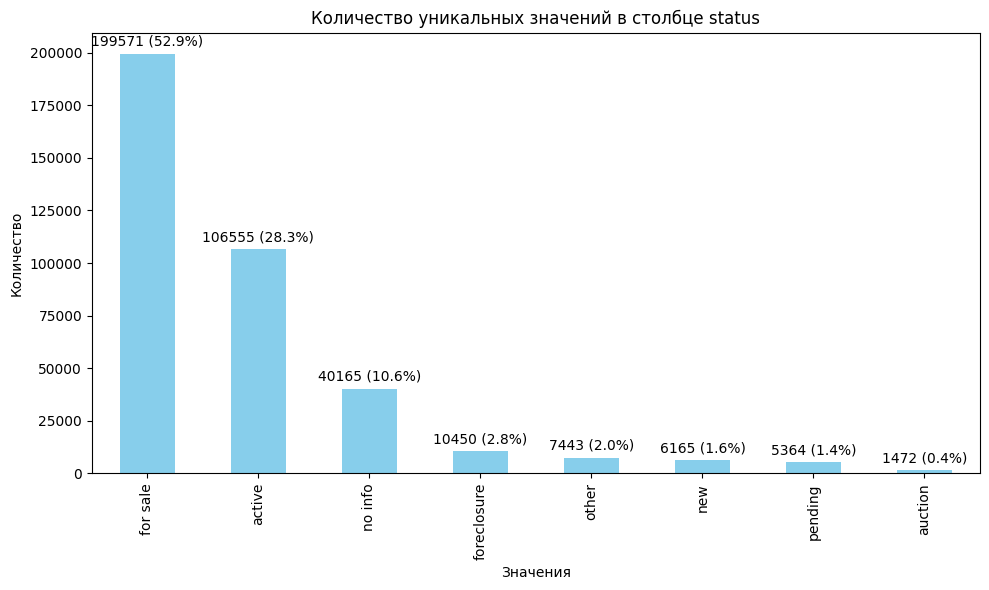

In [11]:
df['status'] = df['status'].apply(lambda x: str(x).lower())
def clean_status(value):
    if 'for sale' in value: return 'for sale'
    elif 'active' in value: return 'active'
    elif 'foreclosure' in value: return 'foreclosure'
    elif 'new' in value: return 'new'
    elif 'pending' in value: return 'pending'
    elif 'auction' in value: return 'auction'
    elif 'nan' in value or pd.isna(value): return 'no info'
    else: return 'other'

df['status'] = df['status'].apply(lambda x: clean_status(x))
df['status'].value_counts().head(20)
plot_value(df, 'status')

Выборка несбалансирована, но в непопулярных значениях встречаются статусы, которые могут сильно сбросить цену недвижимости.

In [12]:
target_correlation(df, 'status')

target_cleaned        1.000000
status_for sale       0.020190
status_new            0.006041
status_no info       -0.005102
status_auction       -0.007656
status_other         -0.016252
status_pending       -0.020181
status_foreclosure   -0.033740
Name: target_cleaned, dtype: float64


Корреляция с целевой переменой показывает более сильную зависимость у некоторых малых значений, на равне или даже больше со значением, описывающим 50% данных

## 1.3 private pool и PrivatePool, mls-id и MlsId<br>

Я предположил что private pool это информация о наличии частного бассейна. Я походил по гугл картам и нашел много подтверждений этого. В одном случае был небольшой бассейн там, где его не должно было быть, но фотография была 2023 года, а датасет не позднее 2020, вполне могли построить. Проверка данных показала, что нет строк, в которых оба поля заполнены. Данные, вероятно, брались из разных источников.<br>
mls-id это идентификатор в брокерской системе, он не нужен

In [13]:
# Количество пустых значений в двух столбцах
empty_column1 = df['private pool'].isna().sum()
empty_column2 = df['PrivatePool'].isna().sum()

# Количество строк с ненулевыми значениями в обоих столбцах
non_empty_both = df['private pool'].notna() & df['PrivatePool'].notna()
count_non_empty_both = non_empty_both.sum()

print(f'Количество пустых значений в столбце private pool: {empty_column1}')
print(f'Количество пустых значений в столбце PrivatePool: {empty_column2}')
print(f'Количество строк с ненулевыми значениями в обоих столбцах: {count_non_empty_both}')

Количество пустых значений в столбце private pool: 373004
Количество пустых значений в столбце PrivatePool: 336874
Количество строк с ненулевыми значениями в обоих столбцах: 0


In [14]:
# Количество пустых значений в двух столбцах
empty_column1 = df['mls-id'].isna().sum()
empty_column2 = df['MlsId'].isna().sum()

# Количество строк с ненулевыми значениями в обоих столбцах
non_empty_both = df['mls-id'].notna() & df['MlsId'].notna()
count_non_empty_both = non_empty_both.sum()

print(f'Количество пустых значений в столбце mls-id: {empty_column1}')
print(f'Количество пустых значений в столбце MlsId: {empty_column2}')
print(f'Количество строк с ненулевыми значениями в обоих столбцах: {count_non_empty_both}')

Количество пустых значений в столбце mls-id: 352243
Количество пустых значений в столбце MlsId: 66880
Количество строк с ненулевыми значениями в обоих столбцах: 0


Нет ни одной строки, где оба этих поля заполнены, думаю можно просто объединить эти столбцы.

In [15]:
df['private_pool'] = df['private pool'].combine_first(df['PrivatePool'])
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)
df['private_pool'] = df['private_pool'].apply(lambda x: str(x).lower())
df['private_pool'] = df['private_pool'].replace('yes', 1).replace('nan', 0).fillna(0)
df['private_pool'].value_counts()

private_pool
0    332693
1     44492
Name: count, dtype: int64

In [16]:
df.drop(['mls-id', 'MlsId'], axis=1, inplace=True)

## 1.4 propertyType

In [17]:
analyze_column(df, 'propertyType')

---
Столбец: propertyType
Тип: object 
Всего значений: 377185
Пропущенные значения: 34733 (9.21%)
Количество уникальных значений: 1280
Количество значений:
propertyType
single-family home                                             92206
Single Family                                                  62869
Single Family Home                                             31728
condo                                                          25968
lot/land                                                       20552
                                                               ...  
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
1 Story, Contemporary, Traditional, Mediterranean                  1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: count, Length: 1280, dtype: int64

Уникальные значения:
['Single F

Тип недвижимости, важное поле в рамках недвижимости, нужно постараться сохранить как можно больше значений.

In [18]:
df['propertyType'] = df['propertyType'].apply(lambda x: str(x).lower())
df['propertyType'].value_counts().head(20)

propertyType
single-family home               92206
single family                    62869
condo                            42529
nan                              34733
single family home               31728
lot/land                         20552
townhouse                        18400
land                             10934
multi-family                      7921
condo/townhome/row home/co-op     7701
traditional                       5913
coop                              3266
multi family                      2794
high rise                         1823
ranch                             1781
mobile/manufactured               1618
detached, one story               1614
single detached, traditional      1581
contemporary                      1557
multi-family home                 1501
Name: count, dtype: int64

In [19]:
df['propertyType'].value_counts()

propertyType
single-family home                                             92206
single family                                                  62869
condo                                                          42529
nan                                                            34733
single family home                                             31728
                                                               ...  
custom, elevated, other                                            1
contemporary, farmhouse                                            1
2 stories, traditional, mediterranean, texas hill country          1
1 story, contemporary, traditional, mediterranean                  1
bilevel, converted dwelling, loft with bedrooms, condo/unit        1
Name: count, Length: 1273, dtype: int64

In [20]:
def clean_propertyType(value):
    if 'nan' in value or pd.isna(value): return 'no info'
    elif 'single-family' in value or 'single family' in value: return 'single-family'
    elif 'multi-family' in value or 'multi family' in value: return 'multi-family'
    elif 'coop' in value or 'cooperative' in value: return 'cooperative'
    elif 'semi-detached' in value: return 'semi-detached'
    elif 'detached' in value: return 'detached'
    elif 'ranch' in value: return 'ranch'
    elif 'condo' in value: return 'condo'
    elif 'lot/land' in value or 'lot' == value or 'land' == value: return 'lot/land'
    elif 'townhouse' in value or 'townhome' in value: return 'townhouse'
    elif 'high rise' in value: return 'high rise'
    elif 'mobile/manufactured' in value or 'mobile' in value or 'manufactured' in value: return 'mobile/manufactured'
    elif 'apartment' in value: return 'apartment'
    # Этажность определена отдельным столбцом в этой таблице, поэтому не будем включать её в other
    elif 'story' in value or 'stories' in value: return 'no info'
    else: return 'other'

df['propertyType'] = df['propertyType'].apply(lambda x: clean_propertyType(x))
df['propertyType'].value_counts().head(20)

propertyType
single-family          186803
condo                   51476
no info                 39637
lot/land                31486
townhouse               18583
other                   18016
multi-family            12218
detached                 5822
cooperative              3801
mobile/manufactured      3529
ranch                    2921
high rise                1952
apartment                 941
Name: count, dtype: int64

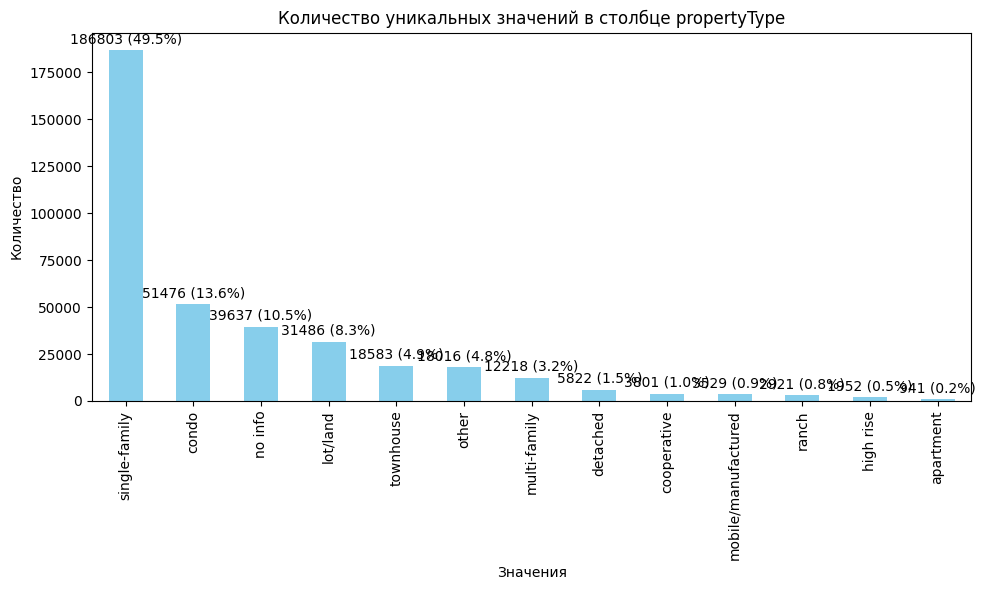

In [21]:
plot_value(df, 'propertyType')

## 1.5 street, city, state

Из улицы извлечем тип улицы, так как в некоторых случаях тип может указывать на богатые районы. После этого оставим во всех столбцах только категории, которые описывают 95% данных

In [23]:
analyze_column(df, 'street')

---
Столбец: street
Тип: object 
Всего значений: 377185
Пропущенные значения: 2 (0.00%)
Количество уникальных значений: 337076
Количество значений:
street
Address Not Disclosed      672
Undisclosed Address        517
(undisclosed Address)      391
Address Not Available      175
Unknown Address             72
                          ... 
16061 SW 144th Ct            1
1721 Deans Crossing Ln       1
20 Pigeon Trl                1
17438 Chase St               1
5983 Midcrown Dr             1
Name: count, Length: 337076, dtype: int64

Уникальные значения:
['240 Heather Ln' '12911 E Heroy Ave' '2005 Westridge Rd' ...
 '15509 Linden Blvd' '7810 Pereida St' '5983 Midcrown Dr']



In [24]:
# Полный справочник типов улиц
street_types = {
    'alley': ['allee', 'ally', 'aly'],
    'annex': ['anex', 'annx', 'anx'],
    'arcade': ['arc'],
    'avenida': [],
    'avenue': ['av', 'ave', 'aven', 'avenu', 'avn', 'avnue'],
    'bayou': ['bayoo', 'byu'],
    'beach': ['bch'],
    'bend': ['bnd'],
    'bluff': ['bluf', 'blf'],
    'bluffs': ['blfs'],
    'bottom': ['bot', 'bottm', 'btm'],
    'boulevard': ['boul', 'boulv', 'bld', 'blvd'],
    'branch': ['brnch', 'br'],
    'bridge': ['brdge', 'brg'],
    'brook': ['brk'],
    'brooks': ['brks'],
    'burg': ['bg'],
    'burgs': ['bgs'],
    'bypass': ['bypa', 'bypas', 'byps', 'byp'],
    'calle': [],
    'camino': [],
    'camp': ['cmp', 'cp'],
    'canyon': ['canyn', 'cnyn', 'cyn'],
    'cape': ['cpe'],
    'causeway': ['causwa', 'cswy'],
    'center': ['cen', 'cent', 'centr', 'centre', 'cnter', 'cntr', 'ctr'],
    'centers': ['ctrs'],
    'circle': ['circ', 'circl', 'crcl', 'crcle', 'cir'],
    'circles': ['cirs'],
    'cliff': ['clf'],
    'cliffs': ['clfs'],
    'club': ['clb'],
    'common': ['cmn'],
    'commons': ['cmns'],
    'corner': ['cor'],
    'corners': ['cors'],
    'course': ['crse'],
    'court': ['ct'],
    'courts': ['cts'],
    'cove': ['cv'],
    'coves': ['cvs'],
    'creek': ['crk'],
    'crescent': ['crsent', 'crsnt', 'cres'],
    'crest': ['crst'],
    'crossing': ['crssng', 'xing'],
    'crossroad': ['xrd'],
    'curve': ['curv'],
    'dale': ['dl'],
    'dam': ['dm'],
    'divide': ['div', 'dvd', 'dv'],
    'drive': ['driv', 'drv', 'dr'],
    'drives': ['drs'],
    'estate': ['est'],
    'estates': ['ests'],
    'expressway': ['exp', 'expr', 'express', 'expw', 'expwy', 'expy'],
    'extension': ['extn', 'extnsn', 'ext'],
    'extensions': ['exts'],
    'fall': [],
    'falls': ['fls'],
    'ferry': ['frry', 'fry'],
    'field': ['fld'],
    'fields': ['flds'],
    'flat': ['flt'],
    'flats': ['flts'],
    'ford': ['frd'],
    'fords': ['frds'],
    'forest': ['frst'],
    'forge': ['forg', 'frg'],
    'forges': ['frgs'],
    'fork': ['frk'],
    'forks': ['frks'],
    'fort': ['frt', 'ft'],
    'freeway': ['freewy', 'frway', 'frwy', 'fwy'],
    'garden': ['gardn', 'grden', 'grdn', 'gdn'],
    'gardens': ['gdns'],
    'gateway': ['gatewy', 'gatway', 'gtway', 'gtwy'],
    'glen': ['gln'],
    'glens': ['glns'],
    'green': ['grn'],
    'greens': ['grns'],
    'grove': ['grov', 'grv'],
    'groves': ['grvs'],
    'harbor': ['harb', 'harbr', 'hrbor', 'hbr'],
    'harbors': ['hbrs'],
    'haven': ['hvn'],
    'heights': ['hts'],
    'highway': ['highwy', 'hiway', 'hiwy', 'hway', 'hwy'],
    'hill': ['hl'],
    'hills': ['hls'],
    'hollow': ['hllw', 'holw', 'holws'],
    'inlet': ['inlt'],
    'island': ['is'],
    'islands': ['iss'],
    'isle': [],
    'junction': ['jction', 'jctn', 'junctn', 'juncton', 'jct'],
    'junctions': ['jcts'],
    'key': ['ky'],
    'keys': ['kys'],
    'knoll': ['knol', 'knl'],
    'knolls': ['knls'],
    'lake': ['lk'],
    'lakes': ['lks'],
    'land': [],
    'landing': ['lndng', 'lndg'],
    'lane': ['la', 'ln'],
    'light': ['lgt'],
    'lights': ['lgts'],
    'loaf': ['lf'],
    'lock': ['lck'],
    'locks': ['lcks'],
    'lodge': ['ldge', 'lodg', 'ldg'],
    'loop': ['lp'],
    'mall': [],
    'manor': ['mnr'],
    'manors': ['mnrs'],
    'meadow': ['mdw'],
    'meadows': ['medows', 'mdws'],
    'mews': [],
    'mill': ['ml'],
    'mills': ['mls'],
    'mission': ['msn'],
    'motorway': ['mtwy'],
    'mount': ['mt'],
    'mountain': ['mtn'],
    'mountains': ['mtns'],
    'neck': ['nck'],
    'orchard': ['orchrd', 'orch'],
    'oval': ['ovl'],
    'overlook': ['ovlk'],
    'overpass': ['opas'],
    'park': ['prk'],
    'parks': ['park'],
    'parkway': ['parkwy', 'pkway', 'pky', 'pkwy'],
    'parkways': ['pkwys'],
    'pass': [],
    'passage': ['psge'],
    'path': [],
    'pike': ['pk'],
    'pine': ['pne'],
    'pines': ['pnes'],
    'place': ['pl'],
    'plain': ['pln'],
    'plains': ['plns'],
    'plaza': ['plza', 'plz'],
    'point': ['pt'],
    'points': ['pts'],
    'port': ['prt'],
    'ports': ['prts'],
    'prairie': ['prr', 'pr'],
    'radial': ['rad', 'radiel', 'radl'],
    'ramp': ['rmp'],
    'ranch': ['rnch', 'rnchs'],
    'rapid': ['rpd'],
    'rapids': ['rpds'],
    'rest': ['rst'],
    'ridge': ['rdge', 'rdg'],
    'ridges': ['rdgs'],
    'river': ['rvr', 'rivr', 'riv'],
    'road': ['rd'],
    'roads': ['rds'],
    'route': ['rte'],
    'row': [],
    'rue': [],
    'run': [],
    'shoal': ['shl'],
    'shoals': ['shls'],
    'shore': ['shr'],
    'shores': ['shrs'],
    'skyway': ['skwy'],
    'spring': ['spng', 'sprng', 'spg'],
    'springs': ['spgs'],
    'spur': [],
    'square': ['sqr', 'sqre', 'squ', 'sq'],
    'squares': ['sqs'],
    'station': ['statn', 'stn', 'sta'],
    'strasse': [],
    'stravenue': ['strav', 'straven', 'stravn', 'strvn', 'strvnue', 'stra'],
    'stream': ['streme', 'strm'],
    'street': ['str', 'strt', 'st'],
    'streets': ['sts'],
    'summit': ['sumit', 'sumitt', 'smt'],
    'terrace': ['terr', 'ter'],
    'throughway': ['trwy'],
    'trace': ['trce'],
    'track': ['trak', 'trk', 'trks'],
    'trafficway': ['trfy'],
    'trail': ['trl'],
    'trailer': ['trlr'],
    'tunnel': ['tunl'],
    'turnpike': ['trnpk', 'turnpk', 'tpke'],
    'underpass': ['upas'],
    'union': ['un'],
    'unions': ['uns'],
    'valley': ['vally', 'vlly', 'vly'],
    'valleys': ['vlys'],
    'via': [],
    'viaduct': ['vdct', 'viadct', 'via'],
    'view': ['vw'],
    'views': ['vws'],
    'village': ['vill', 'villag', 'villg', 'vlg'],
    'villages': ['vlgs'],
    'ville': ['vl'],
    'vista': ['vist', 'vst', 'vsta', 'vis'],
    'walk': [],
    'wall': [],
    'way': ['wy'],
    'well': ['wl'],
    'wells': ['wls']
}

street_types_pattern = r'\b(?:' + '|'.join([re.escape(item) for sublist in [[k] + v for k, v in street_types.items()] for item in sublist]) + r')\b'

def extract_street_type(address):
    address = str(address).lower()
    match = re.search(street_types_pattern, address, re.IGNORECASE)
    if match:
        for street_type, variations in street_types.items():
            if match.group(0) in [street_type] + variations:
                return street_type
    return 'no info'

df['street_type'] = df['street'].apply(lambda x: extract_street_type(x))
#df.drop('street', axis=1, inplace=True)
threshold = determine_threshold(df, 'street_type', top_percent=95)
df = reduce_categories(df, 'street_type', threshold=threshold)
print(df['street_type'].value_counts())

street_type
street       80948
avenue       60702
drive        48350
road         25410
lane         19664
other        19184
court        15043
no info      13850
boulevard    10688
place         9151
way           8047
circle        6823
terrace       5384
mills         4699
park          3616
creek         3295
trail         2973
lake          2843
ridge         2837
hill          1720
cove          1639
highway       1580
river         1512
parkway       1445
valley        1347
point         1315
pine          1229
loop          1226
beach         1174
vista         1115
forest        1094
island        1074
grove         1028
glen           948
view           947
ranch          946
springs        923
canyon         918
meadow         879
club           848
hills          807
spring         777
hollow         770
green          769
run            767
harbor         765
village        737
lakes          720
bend           720
key            696
mountain       628
pass           615


In [25]:
df['city'].fillna('unknown', inplace=True)
threshold = determine_threshold(df, 'city', top_percent=95)
df = reduce_categories(df, 'city', threshold=threshold)
print(df['city'].value_counts())

city
Houston            24442
other              18867
San Antonio        15592
Miami              15524
Jacksonville       10015
                   ...  
Temple Hills          63
North Highlands       62
Worcester             62
Essex                 62
Ashville              62
Name: count, Length: 524, dtype: int64


In [26]:
df['state'].fillna('unknown', inplace=True)
threshold = determine_threshold(df, 'state', top_percent=90)
df = reduce_categories(df, 'state', threshold=threshold)
print(df['state'].value_counts())

state
FL       115449
TX        83786
other     39343
NY        24479
CA        23386
NC        21862
TN        18340
WA        13826
OH        12588
IL         8939
NV         8482
GA         6705
Name: count, dtype: int64


## 1.6 baths и beds

По смыслу столбцы похожи, поэтому будут обработаны одинаково

In [27]:
analyze_column(df, 'baths')

---
Столбец: baths
Тип: object 
Всего значений: 377185
Пропущенные значения: 106338 (28.19%)
Количество уникальных значений: 229
Количество значений:
baths
2 Baths       52466
3 Baths       35506
2             20452
2.0           16576
4 Baths       14764
              ...  
4.75 Baths        1
5.25 Baths        1
41.0              1
1.8 Baths         1
44.0              1
Name: count, Length: 229, dtype: int64

Уникальные значения:
['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba'
 '3.5 ba' '0' '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0'
 '12 Baths' '5.5' '3,500' '1.5 Baths' '2,750' 'Bathrooms: 6' '4.5 Baths'
 '750' '5.5+' '6' '10 Baths' '6 ba' 'Bathrooms: 19' '10.0' '1.5 ba' '4 ba'


Нужно перевести поле в числовой формат

In [28]:
# Функция для преобразования значений в числовой формат
def convert_baths_to_numeric(value):
    if pd.isna(value):
        return 0
    value = str(value).lower()
    # Удаляем слова и символы, оставляя только числа
    value = value.replace('baths', '').replace('bathrooms:', '').replace('ba', '').replace(',', '.').replace('+', '').strip()

    # Обрабатываем сложные случаи, например, '1 / 1-0 / 1-0 / 1-0'
    if '/' in value or '-' in value:
        return 1

    try:
        return float(value)
    except ValueError:
        return 0

# Применяем функцию к столбцу baths
df['baths_numeric'] = df['baths'].apply(convert_baths_to_numeric)

print(df[['baths', 'baths_numeric']])

# Функция для преобразования значений в числовой формат
def convert_beds_to_numeric(value):
    if pd.isna(value):
        return 0
    value = str(value).lower()
    # Удаляем слова и символы, оставляя только числа
    value = value.replace('beds', '')

    # Обрабатываем сложные случаи, например, '1 / 1-0 / 1-0 / 1-0'
    if 'sqft' in value or 'acres' in value:
        return 1

    try:
        return float(value)
    except ValueError:
        return 0

# Применяем функцию к столбцу baths
df['beds_numeric'] = df['beds'].apply(convert_beds_to_numeric)
#
print(df[['beds', 'beds_numeric']])

          baths  baths_numeric
0           3.5            3.5
1       3 Baths            3.0
2       2 Baths            2.0
3       8 Baths            8.0
4           NaN            0.0
...         ...            ...
377180      6.0            6.0
377181  3 Baths            3.0
377182  3 Baths            3.0
377183      NaN            0.0
377184      2.0            2.0

[377185 rows x 2 columns]
              beds  beds_numeric
0                4           4.0
1           3 Beds           3.0
2           3 Beds           3.0
3           5 Beds           5.0
4              NaN           0.0
...            ...           ...
377180           5           5.0
377181      3 Beds           3.0
377182      3 Beds           3.0
377183  8,479 sqft           1.0
377184           3           3.0

[377185 rows x 2 columns]


---
Столбец: baths_numeric
Тип: float64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 83
Количество значений:
baths_numeric
0.0      111181
2.0      103518
3.0       66682
4.0       26333
1.0       18362
          ...  
14.5          1
5.2           1
35.0          1
241.0         1
68.0          1
Name: count, Length: 83, dtype: int64

Уникальные значения:
[3.50e+00 3.00e+00 2.00e+00 8.00e+00 0.00e+00 1.75e+00 4.00e+00 5.00e+00
 1.00e+00 7.00e+00 2.10e+00 2.50e+00 4.50e+00 6.00e+00 5.50e+00 1.50e+00
 1.25e+00 9.00e+00 2.25e+00 1.20e+01 2.75e+00 7.50e+02 1.00e+01 1.90e+01
 7.50e+00 1.80e+01 1.10e+01 1.10e+00 6.50e+00 1.60e+01 1.30e+01 1.40e+01
 8.50e+00 1.70e+01 2.41e+02 1.05e+01 2.00e+01 4.00e+01 2.40e+01 2.20e+01
 3.10e+00 3.25e+00 3.20e+01 2.70e+01 2.60e+01 9.50e+00 1.50e+01 3.50e+01
 3.75e+00 2.90e+01 2.10e+01 5.20e+00 1.45e+01 7.60e+01 2.30e+01 3.30e+00
 4.30e+01 3.40e+01 2.20e+00 5.50e+01 2.50e+01 1.25e+01 4.40e+01 5.00e-01
 4.25e+00 4.75

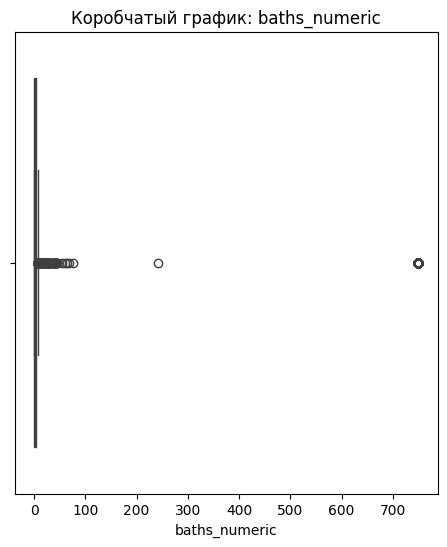

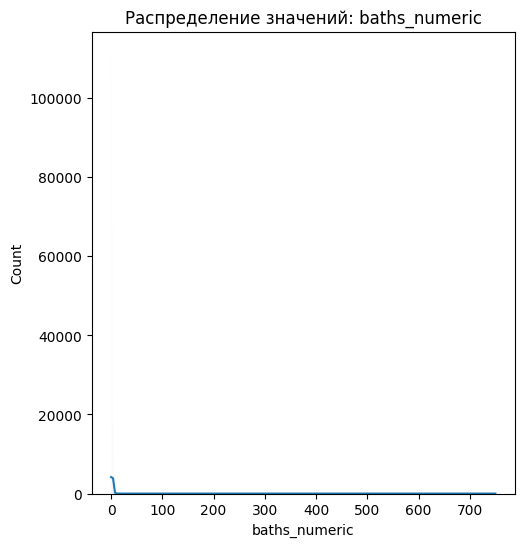

---
Столбец: beds_numeric
Тип: float64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 53
Количество значений:
beds_numeric
0.0      141393
3.0       92953
4.0       60679
2.0       44902
5.0       19067
1.0        8066
6.0        5927
7.0        1678
8.0        1122
9.0         450
10.0        253
12.0        166
11.0        125
16.0         64
13.0         44
64.0         44
14.0         39
15.0         32
18.0         29
24.0         25
20.0         19
17.0         11
32.0          9
28.0          9
22.0          8
26.0          7
34.0          6
19.0          5
21.0          5
27.0          4
40.0          4
23.0          4
30.0          4
36.0          3
25.0          3
44.0          3
42.0          2
29.0          2
78.0          2
48.0          2
33.0          2
47.0          2
99.0          1
31.0          1
53.0          1
51.0          1
75.0          1
39.0          1
144.0         1
52.0          1
76.0          1
35.0          1
88.0

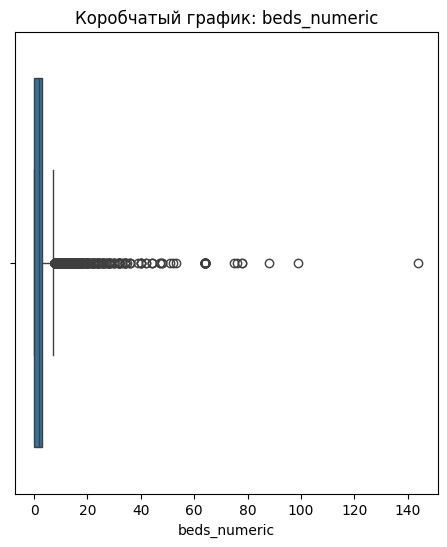

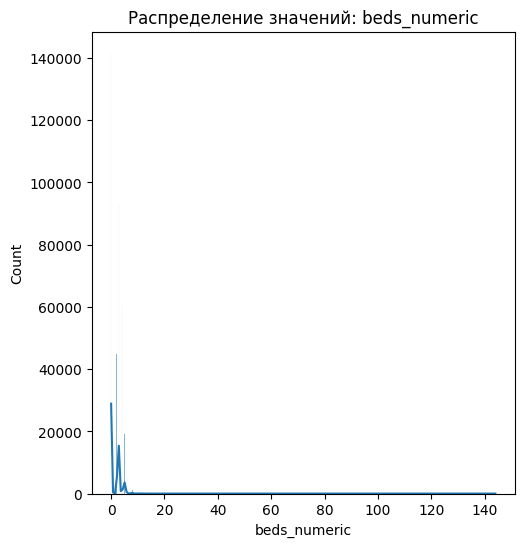

In [29]:
analyze_column(df, 'baths_numeric')
box_column(df, 'baths_numeric')
hist_column(df, 'baths_numeric')
analyze_column(df, 'beds_numeric')
box_column(df, 'beds_numeric')
hist_column(df, 'beds_numeric')

В данных есть выбросы, пожалй я сделаю эти столбцы категориями

In [30]:
df.drop('baths', axis=1, inplace=True)
df.drop('beds', axis=1, inplace=True)

In [31]:
# Функция для категоризации
def categorize_baths(value):
    if value == 0:
        return '0'
    elif value == 1:
        return '1'
    elif value == 2:
        return '2'
    elif value == 3:
        return '3'
    elif value == 4:
        return '4'
    else:
        return '5+'

# Применение функции к столбцу
df['baths_category'] = df['baths_numeric'].apply(categorize_baths)

analyze_column(df, 'baths_category')

# Применение функции к столбцу
df['beds_category'] = df['beds_numeric'].apply(categorize_baths)
#
analyze_column(df, 'beds_category')

---
Столбец: baths_category
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 6
Количество значений:
baths_category
0     111181
2     103518
3      66682
5+     51109
4      26333
1      18362
Name: count, dtype: int64

Уникальные значения:
['5+' '3' '2' '0' '4' '1']

---
Столбец: beds_category
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 6
Количество значений:
beds_category
0     141393
3      92953
4      60679
2      44902
5+     29192
1       8066
Name: count, dtype: int64

Уникальные значения:
['4' '3' '5+' '0' '2' '1']



## 1.7 homeFacts

In [32]:
analyze_column(df, 'homeFacts')

---
Столбец: homeFacts
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 321009
Количество значений:
homeFacts
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                        7174
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                             3532
{'atAGlanceFacts': [{'factValue': '', 'fact

В столбце зашито много признаков, которые нужно извлечь. Присутствует признак стоимости квадратного фута. Возможно можно будет найти целевую переменную перемножая стоимость фута на площадь.

In [33]:
# Функция для парсинга строки и создания столбцов
def parse_home_facts(row):
    home_facts = ast.literal_eval(row['homeFacts'])
    facts = home_facts['atAGlanceFacts']
    result = {}
    for fact in facts:
        result[fact['factLabel']] = fact['factValue']
    return pd.Series(result)

# Применяем функцию к каждому ряду и добавляем новые столбцы
df_parsed = df.apply(parse_home_facts, axis=1)

# Объединение с исходным DataFrame (если нужно)
df = pd.concat([df, df_parsed], axis=1)

# Результат
df.head(5)
df.drop('homeFacts', axis=1, inplace=True)


Year Built - год постройки домов разобьем по десятелетиям<br>
Remodeled year - определим делался ли ремонт за последние 10 лет

In [34]:
# Функция для объединения по десятилетиям
def categorize_by_age(year):
    try:
        # Преобразование входного года в целое число
        year = int(year)
        # Определение текущего года
        current_year = datetime.now().year
        # Вычисление возраста постройки
        age = current_year - year

        # Классификация по возрасту
        if age <= 10:
            return "0-10"
        elif age <= 20:
            return "11-20"
        elif age <= 30:
            return "21-30"
        elif age <= 40:
            return "31-40"
        elif age <= 50:
            return "41-50"
        else:
            return "50+"
    except (ValueError, TypeError):
        return "no info"

# Функция для проверки, прошло ли менее 10 лет с момента ремонта
def remodeled_recently(year):
    if year and year.isdigit():
        return 1 if (datetime.now().year - int(year)) <= 10 else 0
    else:
        return 0

# Применение функций к столбцам
df['Year built'] = df['Year built'].apply(categorize_by_age)
df['Remodeled year'] = df['Remodeled year'].apply(remodeled_recently)

analyze_column(df, 'Year built')
analyze_column(df, 'Remodeled year')

---
Столбец: Year built
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 7
Количество значений:
Year built
50+        123487
no info     63596
0-10        58791
11-20       42765
21-30       33625
41-50       28850
31-40       26071
Name: count, dtype: int64

Уникальные значения:
['0-10' '50+' '11-20' 'no info' '41-50' '21-30' '31-40']

---
Столбец: Remodeled year
Тип: int64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
Remodeled year
0    368212
1      8973
Name: count, dtype: int64

Уникальные значения:
[0 1]



In [35]:
analyze_column(df, 'Heating')
analyze_column(df, 'Cooling')
analyze_column(df, 'Parking')

---
Столбец: Heating
Тип: object 
Всего значений: 377185
Пропущенные значения: 3533 (0.94%)
Количество уникальных значений: 1984
Количество значений:
Heating
                                                                105799
Forced Air                                                       82807
Forced air                                                       51506
Other                                                            29623
Electric                                                         10211
                                                                 ...  
Natural Gas, Space Heater                                            1
Exhaust Fans                                                         1
Central, Exhaust Fans, Natural Gas, Zoned                            1
BR Closet-Electric - new                                             1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor         1
Name: count, Length: 1984, dtype: int64

Уникальные значения:

Эти три поля содержат множество разных значений, которые будет сложно обработать и которые по итогу вряд ли как то существенно повлияют на стоимость, достаточно определить "да" или "нет"

In [36]:
def clean_field(value):
    if pd.isna(value):
        return int(0)
    value = str(value).lower()
    if 'no data' == value or 'none' == value or 'no' == value: return int(0)
    else: return int(1)

df['Heating'] = df['Heating'].apply(lambda x: clean_field(x))
df['Cooling'] = df['Cooling'].apply(lambda x: clean_field(x))
df['Parking'] = df['Parking'].apply(lambda x: clean_field(x))

analyze_column(df, 'Heating')
analyze_column(df, 'Cooling')
analyze_column(df, 'Parking')

---
Столбец: Heating
Тип: int64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
Heating
1    364969
0     12216
Name: count, dtype: int64

Уникальные значения:
[1 0]

---
Столбец: Cooling
Тип: int64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
Cooling
1    355646
0     21539
Name: count, dtype: int64

Уникальные значения:
[1 0]

---
Столбец: Parking
Тип: int64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
Parking
1    357940
0     19245
Name: count, dtype: int64

Уникальные значения:
[1 0]



Числовые поля переведем в числа

In [37]:
def convert_lotsize_to_numeric(value):
    if pd.isna(value) or value.lower() in ['no data', '—', '--']:
        return 0
    value = str(value).lower().replace('sqft', '').replace('sq. ft.', '').replace('lot', '').replace(',', '').strip()

    # Если указаны акры, конвертируем в квадратные футы (1 acre = 43560 sqft)
    if 'acre' in value:
        try:
            acres = float(value.replace('acres', '').replace('acre', '').strip())
            return acres * 43560
        except ValueError:
            return 0
    else:
        try:
            return float(value)
        except ValueError:
            return 0

df['lotsize_numeric'] = df['lotsize'].apply(convert_lotsize_to_numeric)

# Находим моду и заменяем нулевые значения на моду
mode_lotsize = df['lotsize_numeric'][df['lotsize_numeric'] != 0].mode()[0]
df['lotsize_numeric'].replace(0, mode_lotsize, inplace=True)

print(df[['lotsize', 'lotsize_numeric']])

            lotsize  lotsize_numeric
0              None          10890.0
1         5828 sqft           5828.0
2        8,626 sqft           8626.0
3        8,220 sqft           8220.0
4       10,019 sqft          10019.0
...             ...              ...
377180   8,500 sqft           8500.0
377181                       10890.0
377182   1,600 sqft           1600.0
377183         None          10890.0
377184   6,969 sqft           6969.0

[377185 rows x 2 columns]


---
Столбец: lotsize_numeric
Тип: float64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 18740
Количество значений:
lotsize_numeric
10890.0     99356
11325.6      3418
12196.8      2843
6098.0       2733
11761.2      2712
            ...  
26600.0         1
452588.0        1
28844.0         1
43037.0         1
2871.0          1
Name: count, Length: 18740, dtype: int64

Уникальные значения:
[10890.  5828.  8626. ...  4942. 28490.  2871.]



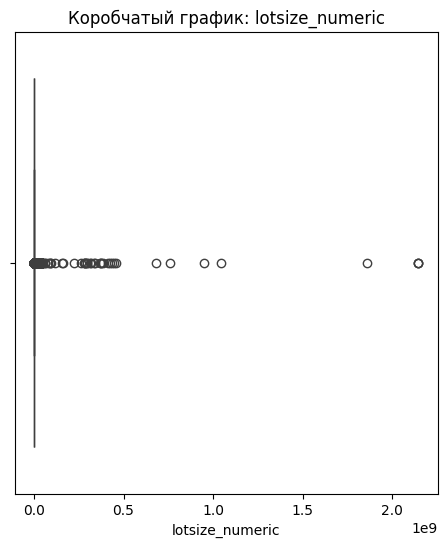

In [38]:
analyze_column(df, 'lotsize_numeric')
box_column(df, 'lotsize_numeric')

Много аномалий, но более детально я рассмотрю их в следующем разделе.

In [39]:
def convert_price_sqft_to_numeric(value):
    value = str(value).lower()
    value = value.replace('$', '').replace(',', '').replace('/sqft', '').replace(' / sq. ft.', '')

    try:
      return int(value)
    except:
      return 0

df['Price/sqft_numeric'] = df['Price/sqft'].apply(convert_price_sqft_to_numeric)

print(df[['Price/sqft', 'Price/sqft_numeric']])
df.drop('Price/sqft', axis=1, inplace=True)

       Price/sqft  Price/sqft_numeric
0            $144                 144
1       $159/sqft                 159
2       $965/sqft                 965
3       $371/sqft                 371
4            None                   0
...           ...                 ...
377180       $311                 311
377181  $337/sqft                 337
377182  $458/sqft                 458
377183       None                   0
377184       $140                 140

[377185 rows x 2 columns]


In [40]:
analyze_column(df, 'Price/sqft_numeric')

---
Столбец: Price/sqft_numeric
Тип: int64 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 3040
Количество значений:
Price/sqft_numeric
0         66102
125        1722
121        1710
128        1708
123        1702
          ...  
374950        1
2949          1
4786          1
4892          1
1620          1
Name: count, Length: 3040, dtype: int64

Уникальные значения:
[ 144  159  965 ... 4489 2675 1620]



## 1.8 fireplace<br>
Переведем в булевый формат

In [41]:
analyze_column(df, 'fireplace')

---
Столбец: fireplace
Тип: object 
Всего значений: 377185
Пропущенные значения: 274071 (72.66%)
Количество уникальных значений: 1652
Количество значений:
fireplace
yes                                                                     50356
Yes                                                                     20856
1                                                                       14544
2                                                                        2432
Not Applicable                                                           1993
                                                                        ...  
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
FAMILYRM, Great Room, Living Room                                           1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets

In [42]:
def clean_fireplace(value):
    if pd.isna(value):
        return int(0)
    value = str(value).lower()
    if 'no data' == value or 'none' == value or 'no' == value or '0' == value: return int(0)
    else: return int(1)

df['fireplace'] = df['fireplace'].apply(lambda x: clean_fireplace(x))

In [43]:
df['fireplace'].value_counts().head(25)

fireplace
0    274631
1    102554
Name: count, dtype: int64

## 1.9 schools<br>
Сложное поле, хранит информацию о ближайших школа, но количество школ может быть любое. Я извлеку взвешенный рейтинг школ (чем ближе школа к дому, тем сильнее её рейтинг влияет на конечное значение), определю наличие рядом хорошей и плохой школы, и определю какие классы обучения доступны рядом с домом.

In [44]:
analyze_column(df, 'schools')

---
Столбец: schools
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 297365
Количество значений:
schools
[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                4204
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]          222
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}]                          168
[{'rating': ['5/10', '3/10', '5/10'], 'data': {'Distance': ['9.71mi', '8.92mi', '1.56mi'], 'Grad

In [45]:
def process_school_info(schools):
    schools = ast.literal_eval(schools)

    ratings = []
    distances = []
    grades = []

    for school in schools:
        if isinstance(school, dict):
            if 'rating' in school and 'data' in school and 'Distance' in school['data']:
                for rating, distance in zip(school['rating'], school['data']['Distance']):
                    # Исключаем 'NA' и 'NR'
                    if rating.isdigit() or '/' in rating:
                        if rating.split('/')[0].isdigit():
                          ratings.append(int(rating.split('/')[0]))
                          distances.append(float(distance.replace(' mi', '').replace('mi', '')))
            if 'data' in school and 'Grades' in school['data']:
                grades.extend(school['data']['Grades'])

    # Взвешенный рейтинг
    if distances and ratings:
        weights = [1/(d if d != 0 else 0.1) for d in distances]
        weighted_rating = np.average(ratings, weights=weights)
    else:
        weighted_rating = np.nan

    # Бинарные признаки
    has_high_rated_school_nearby = int(any(r >= 8 for r in ratings)) if ratings else 0
    has_low_rated_school_nearby = int(any(r <= 4 for r in ratings)) if ratings else 0

    # Обработка классов обучения
    has_primary_school = int(any('PK' in g or 'K' in g or '5' in g or '4' in g for g in grades)) if grades else 0
    has_middle_school = int(any('6' in g or '8' in g for g in grades)) if grades else 0
    has_high_school = int(any('9' in g or '12' in g for g in grades)) if grades else 0

    return pd.Series({
        'Weighted_Rating': weighted_rating,
        'High_Rated_School_Nearby': has_high_rated_school_nearby,
        'Low_Rated_School_Nearby': has_low_rated_school_nearby,
        'Has_Primary_School': has_primary_school,
        'Has_Middle_School': has_middle_school,
        'Has_High_School': has_high_school
    })

processed_data = df['schools'].apply(process_school_info)

df = pd.concat([df, processed_data], axis=1)

df['Weighted_Rating'].fillna(df['Weighted_Rating'].mean(), inplace=True)

print(df.head())


     status   propertyType               street  fireplace            city  \
0    active  single-family       240 Heather Ln          1  Southern Pines   
1  for sale  single-family    12911 E Heroy Ave          0  Spokane Valley   
2  for sale  single-family    2005 Westridge Rd          1     Los Angeles   
3  for sale  single-family  4311 Livingston Ave          1          Dallas   
4  for sale       lot/land       1524 Kiscoe St          0        Palm Bay   

                                             schools        sqft zipcode  \
0  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...        2900   28387   
1  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1,947 sqft   99216   
2  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...  3,000 sqft   90049   
3  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...  6,457 sqft   75205   
4  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...         NaN   32908   

  state stories  ... Parking      lotsize  lotsize_numeric  \
0    NC     

In [46]:
df.head(5)

,status,propertyType,street,fireplace,city,schools,sqft,zipcode,state,stories,...,Parking,lotsize,lotsize_numeric,Price/sqft_numeric,Weighted_Rating,High_Rated_School_Nearby,Low_Rated_School_Nearby,Has_Primary_School,Has_Middle_School,Has_High_School
0,active,single-family,240 Heather Ln,1,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,NC,NaN,...,1,None,10890.0,144,4.811059,0.0,1.0,1.0,1.0,1.0
1,for sale,single-family,12911 E Heroy Ave,0,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,WA,2.0,...,1,5828 sqft,5828.0,159,4.000000,0.0,1.0,1.0,1.0,1.0
2,for sale,single-family,2005 Westridge Rd,1,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,CA,1.0,...,1,"8,626 sqft",8626.0,965,6.861813,1.0,1.0,1.0,1.0,1.0
3,for sale,single-family,4311 Livingston Ave,1,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,TX,3.0,...,1,"8,220 sqft",8220.0,371,9.072483,1.0,0.0,1.0,1.0,1.0
4,for sale,lot/land,1524 Kiscoe St,0,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,FL,NaN,...,1,"10,019 sqft",10019.0,0,4.791703,0.0,1.0,1.0,1.0,1.0


## 1.10 sqft

Размер недвижимости, очищу и приведу в числовой тип

In [47]:
analyze_column(df, 'sqft')

---
Столбец: sqft
Тип: object 
Всего значений: 377185
Пропущенные значения: 40577 (10.76%)
Количество уникальных значений: 25405
Количество значений:
sqft
0                                          11854
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
1,800 sqft                                   563
                                           ...  
9,914                                          1
Total interior livable area: 3,055 sqft        1
5,177                                          1
11620                                          1
Total interior livable area: 4,615 sqft        1
Name: count, Length: 25405, dtype: int64

Уникальные значения:
['2900' '1,947 sqft' '3,000 sqft' ... '4371' '13,870 sqft'
 'Total interior livable area: 4,615 sqft']



In [48]:
def convert_sqft_to_numeric(row):
    value = row['sqft']
    if pd.isna(value):
        if row['Price/sqft_numeric'] != 0:
            return row['target_cleaned'] / row['Price/sqft_numeric']
        else:
            return 0
    else:
        value = str(value).lower()
        value = value.replace('sqft', '').replace(',', '').replace('total interior livable area: ','').replace('--', '0').replace('-', '').strip()
        return float(value)

df['sqft_numeric'] = df.apply(convert_sqft_to_numeric, axis=1)

In [49]:
analyze_column(df, 'sqft_numeric')

---
Столбец: sqft_numeric
Тип: float64 
Всего значений: 377185
Пропущенные значения: 3 (0.00%)
Количество уникальных значений: 10859
Количество значений:
sqft_numeric
0.000000        51991
1200.000000      1432
1000.000000      1080
1500.000000      1015
1800.000000       991
                ...  
32371.000000        1
99552.000000        1
15246.000000        1
1402.173913         1
13870.000000        1
Name: count, Length: 10859, dtype: int64

Уникальные значения:
[ 2900.          1947.          3000.         ...  6193.
  2422.22222222 13870.        ]



In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   status                    377185 non-null  object 
 1   propertyType              377185 non-null  object 
 2   street                    377183 non-null  object 
 3   fireplace                 377185 non-null  int64  
 4   city                      377185 non-null  object 
 5   schools                   377185 non-null  object 
 6   sqft                      336608 non-null  object 
 7   zipcode                   377185 non-null  object 
 8   state                     377185 non-null  object 
 9   stories                   226469 non-null  object 
 10  target                    374704 non-null  object 
 11  target_cleaned            374704 non-null  float64
 12  is_rental                 374704 non-null  float64
 13  private_pool              377185 non-null  i

## 1.11 zipcode<br>
Почтовый индекс, не нужен

In [51]:
df.drop('zipcode', axis=1, inplace=True)

## 1.12 stories<br>
На сколько я понял это этаж или этажность, проведу грубую обработку.

In [52]:
analyze_column(df, 'stories')

---
Столбец: stories
Тип: object 
Всего значений: 377185
Пропущенные значения: 150716 (39.96%)
Количество уникальных значений: 347
Количество значений:
stories
1.0                                  67454
2.0                                  55283
1                                    23086
2                                    18146
3.0                                  11275
                                     ...  
1.2                                      1
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
65.0                                     1
Name: count, Length: 347, dtype: int64

Уникальные значения:
[nan '2.0' '1.0' '3.0' 'One' '2' 'Multi/Split' '4.0' '0.0' '0' 'One Level'
 '1' '9.0' '3' '1 Level, Site Built' 'One Story' '3.00' '1.00' '14.0'
 'Two' '3+' '1 Story' '5.0' '2 Story' 'Ranch/1 Story' 'Condominium'
 'Stories/Levels' '7.0' '2 Level, Site Built' '2 Level' '15'
 '3 Level, Site Built' '4' '22.0

In [53]:
def convert_to_number(value):
    value = str(value).lower()
    if value == 'nan': return 'no info'
    try:
        f = float(value)
        if f == 0:
          return '0'
        elif f == 1:
          return '1'
        elif f == 2:
          return '2'
        elif f == 3:
          return '3'
        else:
          return 'other'
    except ValueError:
        if '1' in value or 'one' in value: return '1'
        if '2' in value or 'two' in value: return '2'
        if '3' in value or 'three' in value or 'tri' in value: return '3'
        else: return 'other'

df['stories_numeric'] = df['stories'].apply(convert_to_number)

print(df[['stories', 'stories_numeric']])
df.drop('stories', axis=1, inplace=True)

       stories stories_numeric
0          NaN         no info
1          2.0               2
2          1.0               1
3          3.0               3
4          NaN         no info
...        ...             ...
377180     0.0               0
377181     9.0           other
377182       2               2
377183     NaN         no info
377184     1.0               1

[377185 rows x 2 columns]


In [54]:
analyze_column(df, 'stories_numeric')

---
Столбец: stories_numeric
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 6
Количество значений:
stories_numeric
no info    150716
1          100608
2           82036
3           17895
other       14416
0           11514
Name: count, dtype: int64

Уникальные значения:
['no info' '2' '1' '3' 'other' '0']



In [55]:
for column in df.columns:
    analyze_column(df, column)

---
Столбец: status
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 8
Количество значений:
status
for sale       199571
active         106555
no info         40165
foreclosure     10450
other            7443
new              6165
pending          5364
auction          1472
Name: count, dtype: int64

Уникальные значения:
['active' 'for sale' 'no info' 'new' 'pending' 'other' 'foreclosure'
 'auction']

---
Столбец: propertyType
Тип: object 
Всего значений: 377185
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 13
Количество значений:
propertyType
single-family          186803
condo                   51476
no info                 39637
lot/land                31486
townhouse               18583
other                   18016
multi-family            12218
detached                 5822
cooperative              3801
mobile/manufactured      3529
ranch                    2921
high rise                1952
apartment            

In [56]:
df.columns

Index(['status', 'propertyType', 'street', 'fireplace', 'city', 'schools',
       'sqft', 'state', 'target', 'target_cleaned', 'is_rental',
       'private_pool', 'street_type', 'baths_numeric', 'beds_numeric',
       'baths_category', 'beds_category', 'Year built', 'Remodeled year',
       'Heating', 'Cooling', 'Parking', 'lotsize', 'lotsize_numeric',
       'Price/sqft_numeric', 'Weighted_Rating', 'High_Rated_School_Nearby',
       'Low_Rated_School_Nearby', 'Has_Primary_School', 'Has_Middle_School',
       'Has_High_School', 'sqft_numeric', 'stories_numeric'],
      dtype='object')

# 2 Статистический анализ

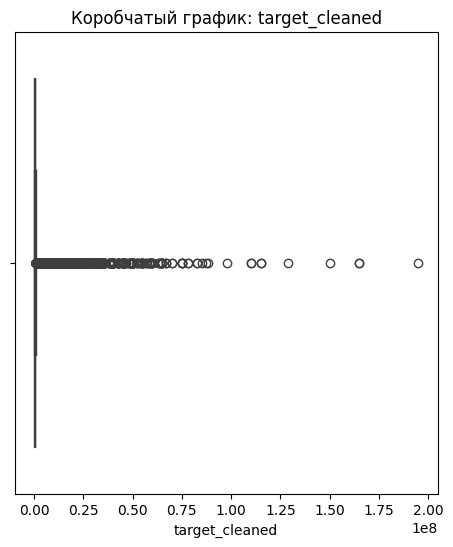

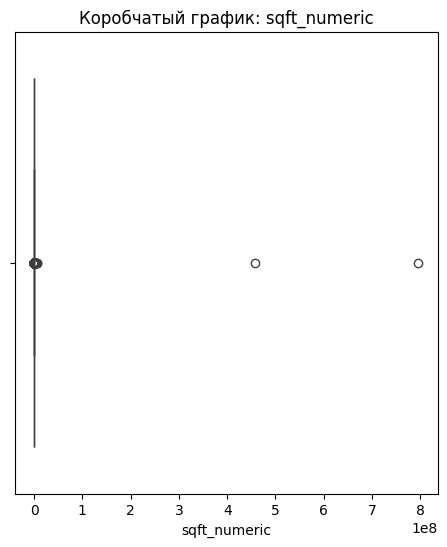

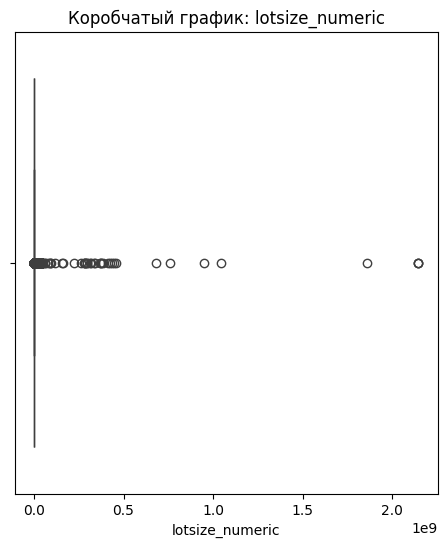

In [57]:
box_column(df, 'target_cleaned')
box_column(df, 'sqft_numeric')
box_column(df, 'lotsize_numeric')

Числовые столбцы содержат крайне много выбросов, проведем дополнительный анализ

In [58]:
df.sort_values(by='target_cleaned', ascending=False).head(20)[['status', 'propertyType', 'street', 'city', 'lotsize_numeric', 'sqft_numeric', 'Price/sqft_numeric', 'target_cleaned']]

,status,propertyType,street,city,lotsize_numeric,sqft_numeric,Price/sqft_numeric,target_cleaned
132425,for sale,single-family,875 Nimes Rd,Los Angeles,282704.4,0.0,0,195000000.0
143528,for sale,single-family,67 Beverly Park Ct,Beverly Hills,236530.8,28660.0,5757,165000000.0
285993,for sale,single-family,67 Beverly Park Ct,Beverly Hills,429937.2,28660.0,5757,165000000.0
110083,for sale,single-family,Tortuoso Way,Los Angeles,457815.6,0.0,0,150000000.0
178931,for sale,single-family,9505 Lania Ln,Beverly Hills,1082901.6,43000.0,3000,129000000.0
119862,for sale,single-family,141 S Carolwood Dr,Los Angeles,431244.0,12201.0,9425,115000000.0
294206,for sale,single-family,141 S Carolwood Dr,Los Angeles,168577.2,12201.0,9425,115000000.0
354264,for sale,lot/land,1441 Angelo Dr,Beverly Hills,576734.4,741.0,148448,110000000.0
54164,for sale,single-family,2571 Wallingford Dr,Beverly Hills,226512.0,38000.0,2895,110000000.0
151594,for sale,condo,172 Madison Ave # LE-PENTHOU,New York,10890.0,19815.0,4946,98000000.0


Данные выглядят верно, значит выбросы это не ошибки и их следует учитывать.

In [59]:
def validate_target_cleaned(df):
    # Удаляем строки с пропущенными значениями и строки, где значения равны нулю
    df_valid = df.dropna(subset=['Price/sqft_numeric', 'sqft_numeric', 'target_cleaned'])

    # Удаляем строки, где значения в 'sqft_numeric' или 'Price/sqft_numeric' равны нулю
    df_valid = df_valid[(df_valid['Price/sqft_numeric'] != 0) & (df_valid['sqft_numeric'] != 0)]

    # Рассчитываем предполагаемое значение target_cleaned
    df_valid['calculated_target'] = df_valid['Price/sqft_numeric'] * df_valid['sqft_numeric']

    # Вычисляем относительное отклонение в процентах
    df_valid['relative_error'] = abs(df_valid['target_cleaned'] - df_valid['calculated_target']) / df_valid['calculated_target'] * 100

    # Считаем ошибочными те строки, где отклонение более 10%
    df_valid['is_correct'] = df_valid['relative_error'] <= 10

    # Выводим строки, где расхождение больше 10%
    incorrect_rows = df_valid[df_valid['is_correct'] == False]

    if incorrect_rows.empty:
        print("Все значения target_cleaned посчитаны правильно.")
    else:
        print("Есть расхождения в следующих строках:")
        print(incorrect_rows[['status', 'propertyType', 'Price/sqft_numeric', 'sqft_numeric', 'target_cleaned', 'calculated_target', 'relative_error']])

# Пример использования
validate_target_cleaned(df)

Есть расхождения в следующих строках:
             status   propertyType  Price/sqft_numeric  sqft_numeric  \
318        for sale    cooperative                   1      373772.0   
390        for sale       lot/land                   3       10000.0   
733        for sale    cooperative                   3      114151.0   
1682        no info  single-family                   1        1572.0   
1726         active          other                   1      119921.0   
...             ...            ...                 ...           ...   
375307  foreclosure  single-family                  80        2728.0   
375520  foreclosure  single-family                   1        1373.0   
376287  foreclosure  single-family                   1        1258.0   
376540  foreclosure          condo                 530        1163.0   
376692  foreclosure          condo                 155        2720.0   

        target_cleaned  calculated_target  relative_error  
318           239000.0           3737

Цена за фут носит рекомендательный характер так как есть много уцененных и завышенных предложений. Не получится просто умножить цену на площать и гарантированной получить правильный результат.

In [60]:
data_sqft = df[df['sqft_numeric'] == 0][['status', 'propertyType', 'lotsize_numeric', 'sqft_numeric', 'Price/sqft_numeric', 'target_cleaned']]
print(data_sqft)
analyze_column(data_sqft, 'propertyType')

          status   propertyType  lotsize_numeric  sqft_numeric  \
4       for sale       lot/land          10019.0           0.0   
15           new        no info           2003.0           0.0   
26        active        no info          10890.0           0.0   
40        active        no info          10890.0           0.0   
41      for sale       lot/land         402930.0           0.0   
...          ...            ...              ...           ...   
377141    active        no info          10890.0           0.0   
377146  for sale  single-family           5488.0           0.0   
377154    active        no info           6970.0           0.0   
377161    active       lot/land              1.0           0.0   
377183   no info        no info          10890.0           0.0   

        Price/sqft_numeric  target_cleaned  
4                        0          5000.0  
15                       0       1650000.0  
26                       0        799000.0  
40                       0 

Много нулевых значений в переменной, на которую в первую очередь будет ориентироваться модель, в основном в предложениях о продаже земли. Посмотрим как это скажется на обучении модели.

Попробуем прикинуть каким скалером лучше обработать числовые данные

In [83]:
def select_scaler(df, columns):
    scalers = {}

    for col in columns:
        data = df[col]

        # Определяем характеристики столбца
        is_normal = np.abs(data.skew()) < 0.5  # Проверка на нормальность
        has_outliers = np.any(np.abs(data - data.mean()) > 3 * data.std())  # Проверка на выбросы
        range_values = data.max() - data.min()

        # Выбор скалера на основе характеристик
        if is_normal:
            scalers[col] = StandardScaler()  # Нормальное распределение
        elif has_outliers:
            scalers[col] = RobustScaler()  # Наличие выбросов
        elif range_values < 1:
            scalers[col] = MinMaxScaler()  # Узкий диапазон
        else:
            # Если данные не нормальные и нет явных выбросов, выбираем между PowerTransformer и QuantileTransformer
            if np.abs(data.kurtosis()) > 3:  # Высокая куртозис (плоское или острое распределение)
                scalers[col] = PowerTransformer()  # Преобразование для улучшения нормальности
            else:
                scalers[col] = QuantileTransformer()  # Преобразование для равномерного распределения

    return scalers

# Пример использования:
# df - ваш DataFrame с данными, columns - список имен числовых столбцов
# target_column - целевой столбец для модели (если нужно для анализа).
scalers = select_scaler(df, ['target_cleaned', 'sqft_numeric', 'lotsize_numeric', 'Price/sqft_numeric'])
print(scalers)

{'target_cleaned': RobustScaler(), 'sqft_numeric': RobustScaler(), 'lotsize_numeric': RobustScaler(), 'Price/sqft_numeric': RobustScaler()}


# 3. Кодирование данных

Города, штаты и улицы будет закодированы с помощью Label, состальные категории через Onehot, числовые столбцы будут нормализованы с помощью Robust из-за большого количества выбросов.

In [62]:
onehot_columns = ['status', 'propertyType', 'stories_numeric', 'baths_category', 'beds_category', 'Year built']
label_columns = ['city', 'state', 'street_type']
numerical_columns = ['sqft_numeric', 'lotsize_numeric', 'Price/sqft_numeric']
passthrough_columns = [
    'fireplace', 'private_pool', 'Remodeled year', 'Heating',
    'Cooling', 'Parking', 'High_Rated_School_Nearby',
    'Low_Rated_School_Nearby', 'Has_Primary_School', 'Has_Middle_School',
    'Has_High_School', 'Weighted_Rating'
]
target_scaler = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_columns),  # OneHotEncoder для категориальных переменных
        ('ordinal', OrdinalEncoder(), label_columns), # OrdinalEncoder для меток
        ('scaler', RobustScaler(), numerical_columns),  # Масштабирование для числовых данных
        ('passthrough', 'passthrough', passthrough_columns)  # Пропуск столбцов без преобразований
    ]
)

Построим корреляционную матрицу

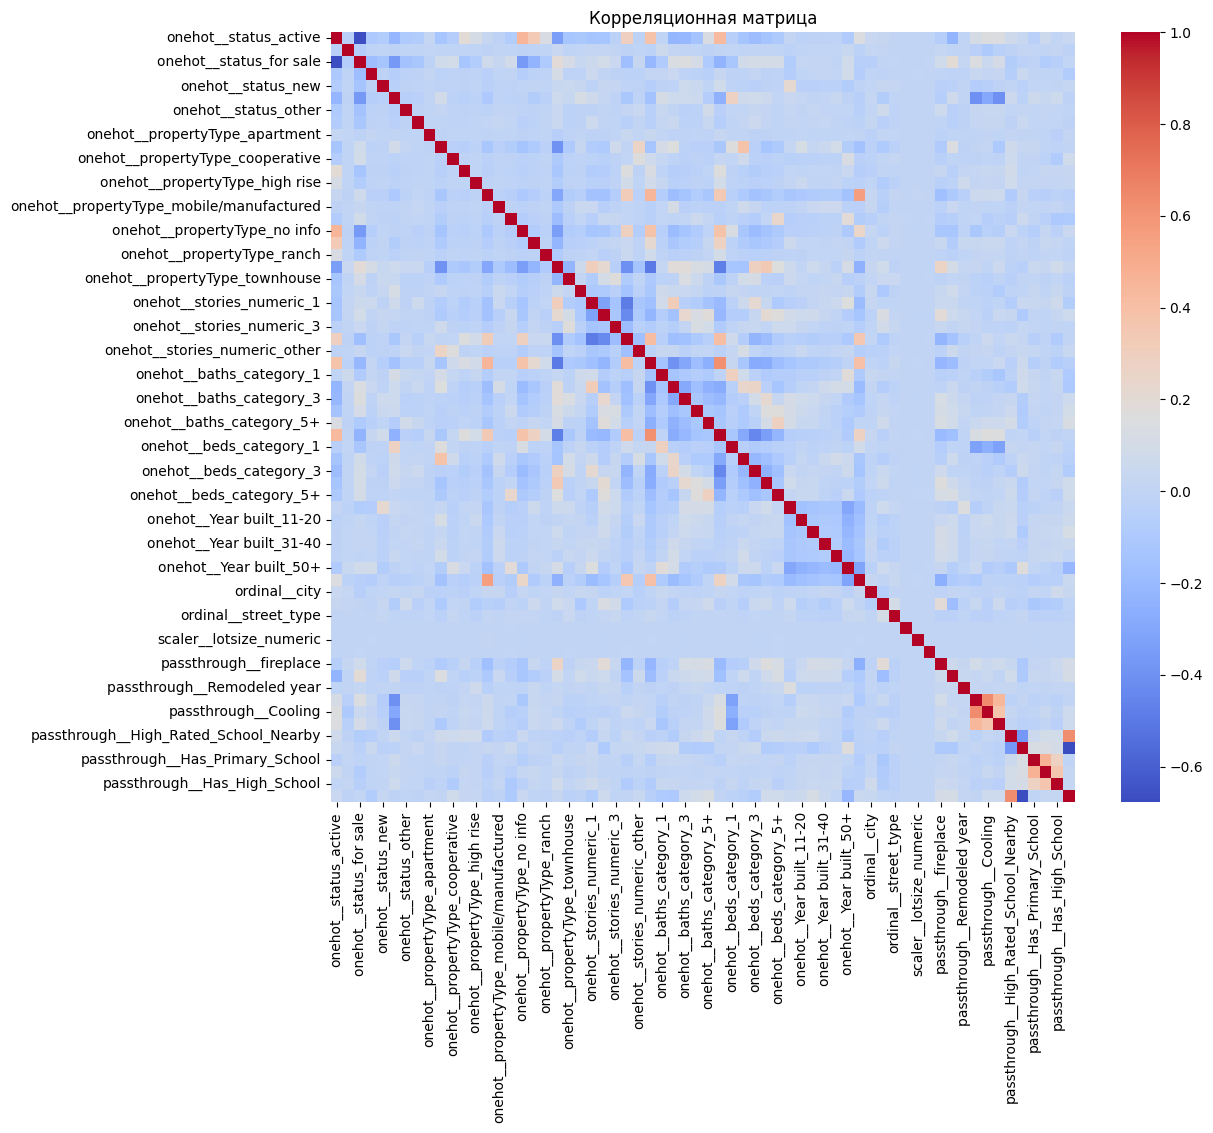

Нет признаков с корреляцией выше порога 0.7


In [86]:
# Разделение на признаки и целевую переменную
data = df
X = data.drop(columns=['target_cleaned'])
y = data['target_cleaned'].values.reshape(-1, 1)  # Целевая переменная в формате (n_samples, 1)

# Преобразуем данные
X_preprocessed = preprocessor.fit_transform(X)

# Получаем имена всех признаков после обработки
encoded_feature_names = preprocessor.get_feature_names_out()

# Преобразуем данные в DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=encoded_feature_names)

# Строим корреляционную матрицу
corr_matrix = X_preprocessed_df.corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

# Установим порог для высокой корреляции
corr_threshold = 0.7

# Найдём все пары признаков с корреляцией выше порога (по абсолютному значению)
high_corr = corr_matrix[(corr_matrix.abs() > corr_threshold) & (corr_matrix != 1)]

# Отфильтруем пары с корреляцией
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Выведем результат
if not high_corr_pairs.empty:
    print("Пары признаков с высокой корреляцией:")
    print(high_corr_pairs)
else:
    print("Нет признаков с корреляцией выше порога", corr_threshold)


Матрица довольно умеренная, нет ярко выраженных кореляций.

# 4 Обучение модели

Задача регрессии<br><br>
Целевые метрики:<br>
<br>
RMSE: больше штрафует ошибки, ведь работаем с деньгами.<br>
R²: показывает, какая доля вариативности целевой переменной объясняется моделью.
<br>
Модели:<br>
Линейную регрессию - самая простая модель<br>
Градиентный бустинг из sklearn и градиентный бустинг CatBoost - мощный и точный алгоритм, попробую разные его реализации.<br>
Дерево решений - простая модель, устойчивая к выбросам<br>
Случайный лес - еще один вариант ансамблвых моделей.<br>

In [64]:
# Функция для расчета метрик
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

In [65]:
def train_models(data, preprocessor, target_scaler, show_feature_importance=False):
    # Разделение на признаки и целевую переменную
    X = data.drop(columns=['target_cleaned'])
    y = data['target_cleaned'].values.reshape(-1, 1)  # Целевая переменная в формате (n_samples, 1)

    # Нормализация целевой переменной с помощью MinMaxScaler
    y_scaled = target_scaler.fit_transform(y)

    # Преобразуем данные
    X_preprocessed = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_scaled, test_size=0.2, random_state=42)

    # 1. Линейная регрессия
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    metrics_lr = calculate_metrics(y_test, y_pred_lr)
    print(f'Линейная регрессия - MAE: {metrics_lr[0]}, MSE: {metrics_lr[1]}, RMSE: {metrics_lr[2]}, R²: {metrics_lr[3]}')

    # 2. Градиентный бустинг
    gbr_model = GradientBoostingRegressor()
    gbr_model.fit(X_train, y_train.ravel())
    y_pred_gbr = gbr_model.predict(X_test)
    metrics_gbr = calculate_metrics(y_test, y_pred_gbr)
    print(f'Градиентный бустинг - MAE: {metrics_gbr[0]}, MSE: {metrics_gbr[1]}, RMSE: {metrics_gbr[2]}, R²: {metrics_gbr[3]}')

    if show_feature_importance:
        print("Feature importance for Gradient Boosting:")
        importance_gbr = pd.Series(gbr_model.feature_importances_, index=feature_names).sort_values(ascending=False)
        print(importance_gbr)

    # 3. CatBoost
    catboost_model = CatBoostRegressor(verbose=0)
    catboost_model.fit(X_train, y_train.ravel())
    y_pred_catboost = catboost_model.predict(X_test)
    metrics_catboost = calculate_metrics(y_test, y_pred_catboost)
    print(f'CatBoost - MAE: {metrics_catboost[0]}, MSE: {metrics_catboost[1]}, RMSE: {metrics_catboost[2]}, R²: {metrics_catboost[3]}')

    if show_feature_importance:
        print("Feature importance for CatBoost:")
        importance_catboost = pd.Series(catboost_model.get_feature_importance(), index=feature_names).sort_values(ascending=False)
        print(importance_catboost)

    # 4. Decision Tree
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    metrics_dt = calculate_metrics(y_test, y_pred_dt)
    print(f'Decision Tree - MAE: {metrics_dt[0]}, MSE: {metrics_dt[1]}, RMSE: {metrics_dt[2]}, R²: {metrics_dt[3]}')

    if show_feature_importance:
        print("Feature importance for Decision Tree:")
        importance_dt = pd.Series(dt_model.feature_importances_, index=feature_names).sort_values(ascending=False)
        print(importance_dt)

    # 5. Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train.ravel())
    y_pred_rf = rf_model.predict(X_test)
    metrics_rf = calculate_metrics(y_test, y_pred_rf)
    print(f'Random Forest - MAE: {metrics_rf[0]}, MSE: {metrics_rf[1]}, RMSE: {metrics_rf[2]}, R²: {metrics_rf[3]}')

    if show_feature_importance:
        print("Feature importance for Random Forest:")
        importance_rf = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
        print(importance_rf)

In [88]:
data_rental = df[df['is_rental'] == 1]
data_rental.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 547 to 376976
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   status                    398 non-null    object 
 1   propertyType              398 non-null    object 
 2   street                    398 non-null    object 
 3   fireplace                 398 non-null    int64  
 4   city                      398 non-null    object 
 5   schools                   398 non-null    object 
 6   sqft                      387 non-null    object 
 7   state                     398 non-null    object 
 8   target                    398 non-null    object 
 9   target_cleaned            398 non-null    float64
 10  is_rental                 398 non-null    float64
 11  private_pool              398 non-null    int64  
 12  street_type               398 non-null    object 
 13  baths_numeric             398 non-null    float64
 14  beds_numer

Данных о недвижимости с ежемесячной платой слишком мало, поэтому они не будут рассматриваться

In [66]:
data = df[df['is_rental'] == 0]
data = data.drop(['is_rental'], axis=1)
train_models(data, preprocessor, target_scaler, show_feature_importance=True)

Линейная регрессия - MAE: 1.4413611321428386, MSE: 20.590388872684507, RMSE: 4.537663371459424, R²: 0.10392604622813773
Градиентный бустинг - MAE: 0.39728702510593794, MSE: 5.227403274203183, RMSE: 2.286351520261743, R²: 0.7725084286247129
Feature importance for Gradient Boosting:
scaler__sqft_numeric                0.450223
scaler__Price/sqft_numeric          0.443817
scaler__lotsize_numeric             0.029006
passthrough__Weighted_Rating        0.020148
onehot__propertyType_cooperative    0.012410
                                      ...   
onehot__stories_numeric_1           0.000000
onehot__propertyType_detached       0.000000
onehot__Year built_31-40            0.000000
onehot__Year built_41-50            0.000000
onehot__status_active               0.000000
Length: 64, dtype: float64
CatBoost - MAE: 0.33969544904267224, MSE: 6.051531674230405, RMSE: 2.4599861126092573, R²: 0.7366431519466338
Feature importance for CatBoost:
scaler__Price/sqft_numeric        30.626506
scaler__s

RandomForest показал самый лучший результат, в целом R² 0.8 считается приемлимой, но попробуем улучшить результат. Как и ожидалось, площадь и цена за метр стали самыми важными метриками.

In [80]:
# Попробует отделить земельные участки и обучить модель отдельно
data = df[df['is_rental'] == 0]
data = data.drop(['is_rental'], axis=1)

# Отдельные данные для земельных участков и зданий
data_buildings = data[data['sqft_numeric'] > 0]
data_land_plots = data[data['sqft_numeric'] == 0]

In [68]:
train_models(data_buildings, preprocessor, target_scaler)

Линейная регрессия - MAE: 1.3725983489024431, MSE: 14.019817613855102, RMSE: 3.744304690307014, R²: 0.143573769894773
Градиентный бустинг - MAE: 0.15980168405578093, MSE: 0.3695571992341065, RMSE: 0.6079121640780899, R²: 0.9774249218024397
CatBoost - MAE: 0.12250547890668366, MSE: 1.233766889239426, RMSE: 1.1107505972266798, R²: 0.9246330904664724
Decision Tree - MAE: 0.04842061652107896, MSE: 0.5981669187773218, RMSE: 0.7734125152706812, R²: 0.963459878485448
Random Forest - MAE: 0.03114557804308531, MSE: 0.3215224936674188, RMSE: 0.5670295350926782, R²: 0.9803592097465309


In [69]:
train_models(data_land_plots, preprocessor, target_scaler)

Линейная регрессия - MAE: 1.85024317196478, MSE: 30.075036269511372, RMSE: 5.4840711400848345, R²: 0.08691210172536312
Градиентный бустинг - MAE: 1.3453543324221586, MSE: 24.752340682768263, RMSE: 4.975172427440909, R²: 0.2485108736404572
CatBoost - MAE: 1.2348143101328715, MSE: 22.841309514511973, RMSE: 4.779258259867526, R²: 0.30653040243914387
Decision Tree - MAE: 1.2469069179562629, MSE: 29.208824609724655, RMSE: 5.404518906408289, R²: 0.11321056989038558
Random Forest - MAE: 1.10184467736658, MSE: 22.844910129863425, RMSE: 4.7796349368820445, R²: 0.3064210865841507


Разделение показало значительное улучшение предсказательной способности у зданий, но предсказание земельных участков оставляет желать лучшего. Так как по условиям задачи мы ищем выгодные сделки, то имеет смысл отказаться от земельных участков и некоторых предложений в пользу качественного большинства. Это будет запасным вариантом.

In [70]:
columns = [
    'fireplace', 'private_pool', 'Remodeled year', 'Heating',
    'Cooling', 'Parking', 'High_Rated_School_Nearby',
    'Low_Rated_School_Nearby', 'Has_Primary_School', 'Has_Middle_School',
    'Has_High_School', 'Weighted_Rating'
]
for column in columns:
    analyze_column(data_land_plots, column)

---
Столбец: fireplace
Тип: int64 
Всего значений: 51518
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
fireplace
0    50356
1     1162
Name: count, dtype: int64

Уникальные значения:
[0 1]

---
Столбец: private_pool
Тип: int64 
Всего значений: 51518
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
private_pool
0    51091
1      427
Name: count, dtype: int64

Уникальные значения:
[0 1]

---
Столбец: Remodeled year
Тип: int64 
Всего значений: 51518
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
Remodeled year
0    51379
1      139
Name: count, dtype: int64

Уникальные значения:
[0 1]

---
Столбец: Heating
Тип: int64 
Всего значений: 51518
Пропущенные значения: 0 (0.00%)
Количество уникальных значений: 2
Количество значений:
Heating
1    48309
0     3209
Name: count, dtype: int64

Уникальные значения:
[1 0]

---
Столбец: Cooling
Тип: int64 
Всего значений: 51518
Пропущенн

Анализ столбцов показал, что у участков столбцы заполняются как и у обычных предложений, удаление столбцов не улучшит результат

In [81]:
onehot_columns_land = ['status', 'propertyType']
label_columns_land = ['city', 'state', 'street_type']
numerical_columns_land = ['lotsize_numeric']
passthrough_columns_land = [
    'High_Rated_School_Nearby',
    'Low_Rated_School_Nearby', 'Has_Primary_School', 'Has_Middle_School',
    'Has_High_School', 'Weighted_Rating'
]
target_scaler_land = RobustScaler()

preprocessor_land = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_columns_land),  # OneHotEncoder для категориальных переменных
        ('ordinal', OrdinalEncoder(), label_columns_land), # OrdinalEncoder для меток
        ('scaler', RobustScaler(), numerical_columns_land),  # Масштабирование для числовых данных
        ('passthrough', 'passthrough', passthrough_columns_land)  # Пропуск столбцов без преобразований
    ]
)

train_models(data_land_plots, preprocessor_land, target_scaler_land)

Линейная регрессия - MAE: 1.810015969982425, MSE: 30.612842460269864, RMSE: 5.532887352935162, R²: 0.07058413058018531
Градиентный бустинг - MAE: 1.3833864970707173, MSE: 26.73602308355326, RMSE: 5.170688840333874, R²: 0.18828562975560303
CatBoost - MAE: 1.2571611289794498, MSE: 23.588837515913838, RMSE: 4.856834104219933, R²: 0.283835208804634
Decision Tree - MAE: 1.2305203895777896, MSE: 28.534343066175364, RMSE: 5.341754680456167, R²: 0.13368804926914812
Random Forest - MAE: 1.1037796340485801, MSE: 22.888745998513723, RMSE: 4.784218431312865, R²: 0.30509021533211766


Данные сложные и не сбалансированные, возможно выбран не тот scaler, попробую перебрать все

In [72]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), QuantileTransformer()]

for scaler in scalers:
    preprocessor_scale = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), onehot_columns),  # OneHotEncoder для категориальных переменных
            ('ordinal', OrdinalEncoder(), label_columns), # OrdinalEncoder для меток
            ('scaler', scaler, numerical_columns),  # Масштабирование для числовых данных
            ('passthrough', 'passthrough', passthrough_columns)  # Пропуск столбцов без преобразований
        ]
    )
    target_scaler_scale = scaler

    print("---------")
    print(scaler)
    train_models(data, preprocessor_scale, target_scaler_scale)

---------
StandardScaler()
Линейная регрессия - MAE: 0.31024336767088834, MSE: 0.9548442141470747, RMSE: 0.9771613040573571, R²: 0.10391318187494403
Градиентный бустинг - MAE: 0.08555881609535959, MSE: 0.24243561729176347, RMSE: 0.4923775150144079, R²: 0.7724829268686356
CatBoost - MAE: 0.07315105547526353, MSE: 0.2806254438732884, RMSE: 0.529740921463774, R²: 0.7366431535536191
Decision Tree - MAE: 0.05018952254071144, MSE: 0.2591353063818822, RMSE: 0.5090533433559613, R²: 0.7568108716383389
Random Forest - MAE: 0.04289940252323486, MSE: 0.20333209636230914, RMSE: 0.4509236036872645, R²: 0.8091801693381429
---------
MinMaxScaler()
Линейная регрессия - MAE: 0.002930921662948286, MSE: 8.52184823910174e-05, RMSE: 0.009231385724311243, R²: 0.10391283910331883
Градиентный бустинг - MAE: 0.0014066410493161444, MSE: 2.5357826608518838e-05, RMSE: 0.005035655529175803, R²: 0.7333580437647749
CatBoost - MAE: 0.0006910685834441465, MSE: 2.5045410630514446e-05, RMSE: 0.005004539002796806, R²: 0.7

QuantileTransformer показал отличный результат, лучшими моделями оказались RandomForest и CatBoost. Проведем поиск параметров и кросс-валидацию

In [73]:
onehot_columns = ['status', 'propertyType', 'stories_numeric', 'baths_category', 'beds_category', 'Year built']
label_columns = ['city', 'state', 'street_type']
numerical_columns = ['sqft_numeric', 'lotsize_numeric', 'Price/sqft_numeric']
passthrough_columns = [
    'fireplace', 'private_pool', 'Remodeled year', 'Heating',
    'Cooling', 'Parking', 'High_Rated_School_Nearby',
    'Low_Rated_School_Nearby', 'Has_Primary_School', 'Has_Middle_School',
    'Has_High_School', 'Weighted_Rating'
]
target_scaler_quantile = QuantileTransformer()

preprocessor_quantile = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_columns),
        ('ordinal', OrdinalEncoder(), label_columns),
        ('scaler', QuantileTransformer(), numerical_columns),
        ('passthrough', 'passthrough', passthrough_columns)
    ]
)

data = df[df['is_rental'] == 0]
data = data.drop(['is_rental'], axis=1)

X = data.drop(columns=['target_cleaned'])
y = data['target_cleaned'].values.reshape(-1, 1)

y_scaled = target_scaler_quantile.fit_transform(y)

X_preprocessed = preprocessor_quantile.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_scaled, test_size=0.2, random_state=42)

In [74]:
# Функция для кросс-валидации
def cross_validate(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    rmse_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train.ravel())

        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

    print(f'Среднее RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')
    print(f'Среднее R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}')

In [75]:
param_grid = {
    'iterations': [200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

model = CatBoostRegressor(silent=True)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры для CatBoost: {grid_search.best_params_}')

catboost_best_g = grid_search.best_estimator_
y_pred = catboost_best_g.predict(X_test)
metrics_catboost = calculate_metrics(y_test, y_pred)
print(f'CatBoost - MAE: {metrics_catboost[0]}, MSE: {metrics_catboost[1]}, RMSE: {metrics_catboost[2]}, R²: {metrics_catboost[3]}')

Лучшие параметры для CatBoost: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
CatBoost - MAE: 0.025996593599448774, MSE: 0.005461695535621983, RMSE: 0.07390328501238617, R²: 0.9353123471252149


In [76]:
param_distributions = {
    'iterations': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1, 2],
}

model = CatBoostRegressor(silent=True)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=50, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print(f'Лучшие параметры для CatBoost: {random_search.best_params_}')

# Обучение с лучшими параметрами
catboost_best_r = random_search.best_estimator_
y_pred = catboost_best_r.predict(X_test)
metrics_catboost = calculate_metrics(y_test, y_pred)
print(f'CatBoost - MAE: {metrics_catboost[0]}, MSE: {metrics_catboost[1]}, RMSE: {metrics_catboost[2]}, R²: {metrics_catboost[3]}')

Лучшие параметры для CatBoost: {'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 10, 'bagging_temperature': 0.5}
CatBoost - MAE: 0.02685605693991985, MSE: 0.005577019644527474, RMSE: 0.07467944593077451, R²: 0.9339464625063605


In [77]:
print("CatBoost Grid")
cross_validate(catboost_best_g, X_train, y_train)
print("CatBoost Random")
cross_validate(catboost_best_r, X_train, y_train)

CatBoost Grid
Среднее RMSE: 0.0745 ± 0.0005
Среднее R²: 0.9340 ± 0.0010
CatBoost Random
Среднее RMSE: 0.0753 ± 0.0004
Среднее R²: 0.9326 ± 0.0006


Немного улучшился результат CatBoost, модель стабильна

In [78]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train.ravel())

print(f'Лучшие параметры для RandomForest: {grid_search_rf.best_params_}')

# Обучение с лучшими параметрами
rf_best_g = grid_search_rf.best_estimator_
y_pred_rf = rf_best_g.predict(X_test)
metrics_rf = calculate_metrics(y_test, y_pred_rf)
print(f'Random Forest - MAE: {metrics_rf[0]}, MSE: {metrics_rf[1]}, RMSE: {metrics_rf[2]}, R²: {metrics_rf[3]}')

Лучшие параметры для RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - MAE: 0.022284976119993676, MSE: 0.005698345918736545, RMSE: 0.07548738913710386, R²: 0.9325094889769062


In [79]:
print("RandomForest Grid")
cross_validate(rf_best_g, X_train, y_train)

RandomForest Grid
Среднее RMSE: 0.0766 ± 0.0005
Среднее R²: 0.9303 ± 0.0009


Для случайного леса не удалось подобрать лучшие параметры из-за большого объема вычислений. В данном варианте я поставил параметры-заглушку, чтобы вычисление просто могли закончиться. По этой же причине я не стал прогонять RandomSearch. С этими параметрами результат немного хуже, но модель стабильная.

# Итог

В данной работе был произведен анализ среза базы данных агенства по продаже недвижимости. Данные были обработаны, проанализированы и адаптированы для обучения моделей.
Получившаяся оценка моделей хорошая и так как задание не ставит цель достичь определенных метрик, я считаю разработку законченой. Лучше всего себя показали CatBoost и RandomForest (RMSE: ~0.075 и R²: ~0.93)
Метрики моделей всё еще можно улучшить как минимум двумя способами:
- посчитать качественные параметры для случайного леса на более мощной машине;
- условие задачи "Ваша задача — разработать модель, которая позволила бы обойти
конкурентов по скорости и качеству совершения сделок." позволяет отказаться от относительно небольшого количества "неудобных" предложений чтобы получить практически идеальное предсказание для остальных предложений.